In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchdiffeq 
import zuko
from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.preprocessing import StandardScaler
from torch import Tensor
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from typing import *
import numpy as np
from zuko.utils import odeint
import pandas as pd

In [4]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from entot.models.utils import MLP, MLP_FM

from ott.solvers.nn.models import ModelBase, NeuralTrainState
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds
from typing import Any
from flax.training.train_state import TrainState
import tensorflow as tf
import tensorflow_datasets as tfds

2023-07-10 10:21:15.534959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/dominikk/mambaforge/envs/ott/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from flax.training import train_state
import flax.linen as nn
import jax.numpy as jnp

class MLP_FM(ModelBase):
    dim_hidden: Sequence[int]
    is_potential: bool = False
    act_fn: Callable[[jnp.ndarray], jnp.ndarray] = nn.leaky_relu
    noise_dim: int = 0
    output_dim: Optional[int] = None
    n_frequencies: int = 1

    def time_encoder(self, t: jnp.array) -> jnp.array:
        freq = 2 * jnp.arange(self.n_frequencies) * jnp.pi
        t = freq * t#[..., None]
        return jnp.concatenate((jnp.cos(t), jnp.sin(t)), axis=-1)


    @nn.compact
    def __call__(self, t: float, x: jnp.ndarray, noise: jnp.ndarray) -> jnp.ndarray:  # noqa: D102
        
        t = jnp.full(shape=(len(x), 1), fill_value=t)
        t = self.time_encoder(t)
        
        if x.ndim==3:
            x=jnp.squeeze(x)

        if noise.ndim==3:
            noise = jnp.squeeze(noise)
            
        squeeze = x.ndim == 1
        if squeeze:
            x = jnp.expand_dims(x, 0)
        

        squeeze = noise.ndim == 1
        if squeeze:
            noise = jnp.expand_dims(noise, 0)

        assert x.ndim == 2, x.ndim
        assert noise.ndim==2, noise.dim
        n_input = x.shape[-1]

        #if noise.ndim > 1 and noise.shape[-1] > 0:
        z = jnp.concatenate((x, noise, t), axis=-1)
        #else:
        #    z = jnp.concatenate((x, t), axis=-1)
        for n_hidden in self.dim_hidden:
            Wx = nn.Dense(n_hidden, use_bias=True)
            z = self.act_fn(Wx(z))

        if self.is_potential:
            Wx = nn.Dense(1, use_bias=True)
            z = Wx(z).squeeze(-1)

            quad_term = 0.5 * jax.vmap(jnp.dot)(x, x)
            z += quad_term
        elif self.output_dim is None:
            Wx = nn.Dense(n_input - self.noise_dim, use_bias=True)
            z = Wx(z)
        else:
            Wx = nn.Dense(self.output_dim, use_bias=True)
            z = Wx(z)

        return z.squeeze(0) if squeeze else z

    def create_train_state(
        self, rng: jax.random.PRNGKeyArray, optimizer: optax.OptState, source_dim: int, noise_dim: int, **kwargs: Any
    ) -> NeuralTrainState:
        params = self.init(rng, jnp.ones((1,)), jnp.ones(source_dim), jnp.ones(noise_dim))["params"]
        return train_state.TrainState.create(apply_fn=self.apply, params=params, tx=optimizer)

In [6]:
from entot.models.utils import MixtureNormalSampler
source = MixtureNormalSampler([0], 1,  0.5, batch_size=2048)(jax.random.PRNGKey(0))
target = MixtureNormalSampler([-1.0,1.0], 1,  0.1, batch_size=2048)(jax.random.PRNGKey(0))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
from typing import Any
import ott
from functools import partial


class OTFlowMatching:
    def __init__(self, neural_net: Type[ModelBase], input_dim: int, iterations: int, opt: Optional[Any]= None) -> None:
        self.optimizer = optax.adamw(learning_rate=1e-4, weight_decay=1e-10) if opt is None else opt
        self.noise_fn = partial(jax.random.multivariate_normal, mean=jnp.zeros((input_dim[0],)), cov=jnp.diag(jnp.ones((input_dim[0], ))))
        self.input_dim = input_dim
        self.std = 1.0
        self.noise_dim=input_dim[0] # only works for flattened data
        self.rng = jax.random.PRNGKey(0)
        self.k_noise_per_x: int = 1
        self.iterations = iterations
        
        self.neural_net = neural_net

        self.state_mlp: Optional[TrainState] = None

        self.setup(self.input_dim, self.noise_dim, self.neural_net, self.optimizer)
    
    def setup(self, input_dim: int, noise_dim: int, neural_net: Type[ModelBase], optimizer: optax.OptState) -> None:
        #self.state_mlp = neural_net.create_train_state(self.rng, optimizer, (*input_dim[:-1], input_dim[-1] + noise_dim + 1))
        self.state_mlp = neural_net.create_train_state(self.rng, optimizer, input_dim, input_dim)
        
        self.step_fn = self._get_step_fn()
        self.match_fn = self._get_match_fn()
        self.match_latent_fn = self._get_match_latent_fn()


    def __call__(self, x: jnp.array, y: jnp.array, batch_size_source: int, batch_size_target: int) -> Any:
        x_loader = iter(tf.data.Dataset.from_tensor_slices(x).repeat().shuffle(buffer_size=10_000).batch(batch_size_source))
        y_loader = iter(tf.data.Dataset.from_tensor_slices(y).repeat().shuffle(buffer_size=10_000).batch(batch_size_target))

        batch: Dict[str, jnp.array] = {}
        for step in tqdm(range(self.iterations)):

            x_batch, y_batch = tfds.as_numpy(next(x_loader)), tfds.as_numpy(next(y_loader))
            self.rng, rng_time, rng_noise = jax.random.split(self.rng, 3)
            source_batch = jnp.tile(x_batch, (self.k_noise_per_x, *((1,) * (x_batch.ndim-1))))
            noise_shape = (
                (*source_batch.shape[:-1], self.noise_dim)
                if len(source_batch.shape[:-1]) > 1
                else (source_batch.shape[:-1][0], self.noise_dim)
            )
            latent_batch = jnp.squeeze(self.noise_fn(rng_noise, shape=noise_shape), axis=-1) * self.std
            # IMPORTANT: here we swap noise and source, as source is treated as condition, and we want to map noise to data
            source_batch, y_batch = self.match_fn(source_batch, y_batch)
            #latent_batch = self.match_latent_fn(latent_batch, y_batch)
            batch["source"] = latent_batch
            batch["noise"] = source_batch
            batch["target"] = y_batch
            batch["time"] = jax.random.uniform(rng_time, (len(source_batch), 1))
            self.state_mlp = self.step_fn(self.state_mlp, batch)

    def _get_match_fn(self) -> Callable:
        
        @jax.jit
        def match_pairs(x: jnp.ndarray, y: jnp.ndarray) -> Tuple[jnp.array, jnp.array]:
            geom = ott.geometry.pointcloud.PointCloud(x, y, epsilon=1e-1, scale_cost="mean")
            out = ott.solvers.linear.sinkhorn.Sinkhorn(threshold=1e-2)(
                ott.problems.linear.linear_problem.LinearProblem(geom)
            )
            pi_star_inds = jax.random.categorical(
                jax.random.PRNGKey(0), logits=jnp.log(out.matrix.flatten()), shape=(len(x),)
            )
            inds_source = pi_star_inds // len(y)
            inds_target = pi_star_inds % len(y)
            return x[inds_source], y[inds_target]
        return match_pairs
    
    def _get_match_latent_fn(self) -> Callable:
        
        @jax.jit
        def match_left_to_right(x: jnp.ndarray, y: jnp.ndarray) -> Tuple[jnp.array, jnp.array]:
            geom = ott.geometry.pointcloud.PointCloud(x, y, epsilon=1e-1, scale_cost="mean")
            out = ott.solvers.linear.sinkhorn.Sinkhorn(threshold=1e-2)(
                ott.problems.linear.linear_problem.LinearProblem(geom)
            )
            inds_source = jax.vmap(lambda tmap: jax.random.categorical(
                jax.random.PRNGKey(0), logits=jnp.log(tmap), shape=(1,)
            ))(out.matrix)

            return x[jnp.squeeze(inds_source)]
        return match_left_to_right

    def _get_step_fn(self) -> Callable:
        def psi_t(x_0, x_1, t):
            return (1-t)*x_0+t*x_1
        
        def loss_fn(params_mlp: jnp.array, apply_fn_mlp: Callable, batch: Dict[str, jnp.array]):
            psi_t_eval = psi_t(batch["source"], batch["target"], batch["time"])
            mlp_pred = apply_fn_mlp({"params": params_mlp}, batch["time"], psi_t_eval, batch["noise"])
            d_psi = batch["target"] - batch["source"]
            if len(mlp_pred.shape) == 1:
                mlp_pred = mlp_pred[:, None]
            return jnp.mean(optax.l2_loss(mlp_pred, d_psi))
        
        def transform_t(t: float) -> float: #TODO: adapt
            return t 
        
        @jax.jit
        def step_fn(state_neural_net: TrainState, batch: Dict[str, jnp.array]):
            grad_fn = jax.value_and_grad(loss_fn, argnums=0, has_aux=False)
            val, grads_mlp = grad_fn(state_neural_net.params, state_neural_net.apply_fn, batch)

            return state_neural_net.apply_gradients(grads=grads_mlp)
        
        return step_fn
    
        

    def transport(self, x: jnp.array, samples_per_x: int = 1, seed: int = None) -> jnp.array:
        assert x.ndim==len(self.input_dim)+1
        rng = jax.random.PRNGKey(seed)
        source_batch = x#jnp.tile(x, (samples_per_x, *((1,) * (x.ndim-1))))
        noise_shape = (
            (*source_batch.shape[:-1], self.noise_dim)
            if len(source_batch.shape[:-1]) > 1
            else (source_batch.shape[:-1][0], self.noise_dim)
        )
        latent_batch = jnp.squeeze(self.noise_fn(rng, shape=noise_shape), axis=-1) * self.std
        
        apply_fn_partial = partial(self.state_mlp.apply_fn, noise=source_batch) # note that here we swap source and noise    
        solution = diffrax.diffeqsolve(
                    #diffrax.ODETerm(lambda t,y, args: apply_fn_mlp({"params": params_mlp}, t, y, args)),
                    #diffrax.ODETerm(lambda t, y, args: partial_eval(t, y)),
                    diffrax.ODETerm(lambda t,y,args: apply_fn_partial({"params":self.state_mlp.params}, t=t, x=y)),
                    diffrax.Tsit5(),
                    t0=0,
                    t1=1,
                    dt0=None,
                    y0=latent_batch, # here we swap source and noise
                    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                    #saveat=diffrax.SaveAt(ts=ts),
                    )
        t_xz =solution.ys
        #t_xz = self.state_mlp.apply_fn({"params": self.state_mlp.params}, jnp.concatenate((x_with_noise, jnp.zeros((len(x_with_noise),)), axis=-1)))
        return jnp.reshape(t_xz, (samples_per_x, *(x.shape)))



        



In [16]:
neural_net = MLP_FM([64, 64, 64, 64], n_frequencies=10)

In [17]:
#f = partial(otfm.state_mlp.apply_fn, noise=jnp.ones(len(source),))
#f({"params":otfm.state_mlp.params}, t=jnp.zeros((len(source), 1)), x=source)

In [22]:
otfm = OTFlowMatching(neural_net, input_dim=[1], iterations=3000)

In [23]:
otfm(source, target, 256, 256)

100%|██████████| 3000/3000 [36:32<00:00,  1.37it/s]


<Axes: ylabel='Density'>

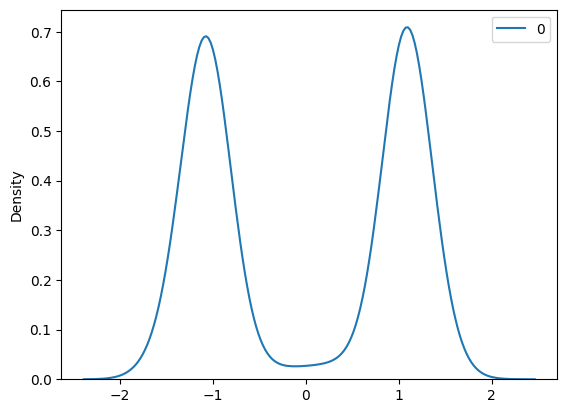

In [24]:
import seaborn as sns
res = otfm.transport(source, seed=0)
sns.kdeplot(res[0,...])

<Axes: ylabel='Density'>

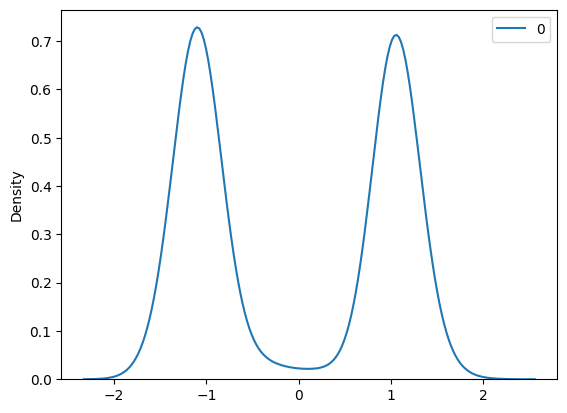

In [15]:
import seaborn as sns
res = otfm.transport(source, seed=0)
sns.kdeplot(res[0,...])

In [47]:
res = otfm.transport(source, seed=0)

<Axes: ylabel='Density'>

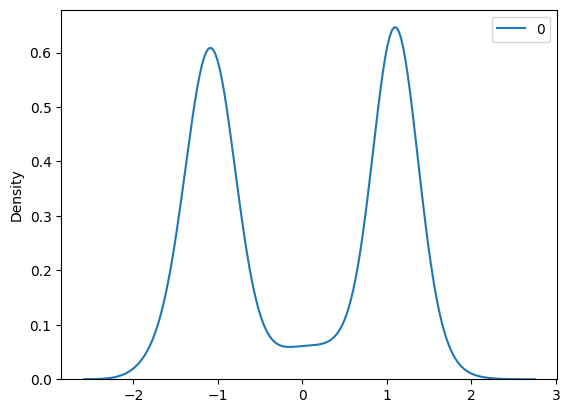

In [48]:
import seaborn as sns
sns.kdeplot(res[0,...])

In [25]:
source_repeat = jnp.ones((1,)) * -0.5
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const = otfm.transport(source_repeat, seed=0)

<Axes: ylabel='Density'>

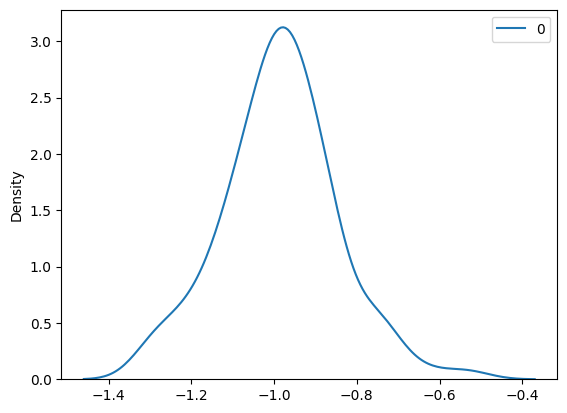

In [26]:
sns.kdeplot(res_const[0,...])

<Axes: ylabel='Density'>

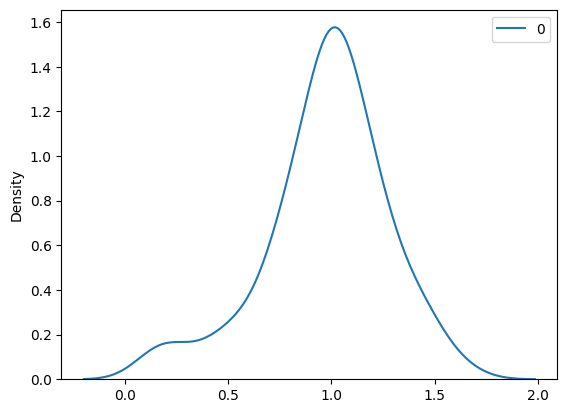

In [40]:
source_repeat = jnp.ones((1,)) * 0.5
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const = otfm.transport(source_repeat, seed=0)
sns.kdeplot(res_const[0,...])

<Axes: ylabel='Density'>

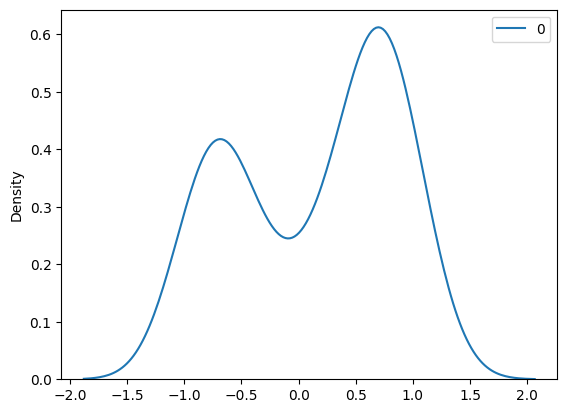

In [41]:
source_repeat = jnp.ones((1,)) * 0.0
source_repeat = jnp.repeat(source_repeat, 100)[:, None]
res_const = otfm.transport(source_repeat, seed=0)
sns.kdeplot(res_const[0,...])